<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#accuracy-score" data-toc-modified-id="accuracy-score-1">accuracy score</a></span></li><li><span><a href="#validation-loss" data-toc-modified-id="validation-loss-2">validation loss</a></span></li><li><span><a href="#ROC-curve" data-toc-modified-id="ROC-curve-3">ROC curve</a></span></li><li><span><a href="#PR-curve" data-toc-modified-id="PR-curve-4">PR curve</a></span></li><li><span><a href="#confusion-matrix" data-toc-modified-id="confusion-matrix-5">confusion matrix</a></span></li><li><span><a href="#classification-report" data-toc-modified-id="classification-report-6">classification report</a></span></li></ul></div>

Matched leptonJet _vs_ (misreconstruction+background)

In [1]:
import os

import awkward
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

import utils.histoHelpers as uhh
from mvatrain.xgboost2tmva import convert_model
from mvatrain.ROCPlot import ROCPlot


plt.style.use('default')
plt.rcParams.update(uhh.ffPltStyleSettings)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
dataset_ = awkward.load(os.path.join(os.environ['FFANA_BASE'], 'mvatrain/data/combo_190513.awkd'))

In [3]:
# datasetDf = pd.DataFrame(dict(dataset_))
# datasetDf.tail()

In [4]:
X = np.column_stack([dataset_[k] for k in dataset_ if k !='target'])
y = dataset_['target']

In [5]:
print(X.shape)
print(y.shape)

(2873263, 14)
(2873263,)


In [6]:
np.isnan(X).sum(0)

array([      0,       0,       0, 2013392, 2013392,       1,       0,
             0,       0,       0,       0,       0,   28674,   84300])

In [7]:
X_ = np.nan_to_num(X)
np.isnan(X_).sum(0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
feature_names = [x for x in dataset_.keys() if x != 'target']
feature_names

['pt',
 'eta',
 'neufrac',
 'maxd0',
 'mind0',
 'tkiso',
 'pfiso',
 'spreadpt',
 'spreaddr',
 'lambda',
 'epsilon',
 'ecf1',
 'ecf2',
 'ecf3']

In [9]:
X_trainVal, X_test, y_trainVal, y_test = train_test_split(X_, y, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, random_state=2019)

dtrain = xgb.DMatrix(X_train, label=y_train, missing=np.nan, feature_names=feature_names, nthread=16)
dval = xgb.DMatrix(X_val, label=y_val, missing=np.nan, feature_names=feature_names, nthread=16)
dtest = xgb.DMatrix(X_test, label=y_test, missing=np.nan, feature_names=feature_names, nthread=16)

In [10]:
# https://xgboost.readthedocs.io/en/latest/parameter.html
param = dict(
    ## General Parameters
    booster='gbtree', # default
    verbosity=1, # warning
    nthread=16,
    ## Tree booster
    max_depth=3,
    learning_rate=0.5, # eta
    ## learning task parameters
    objective='binary:logitraw',
    eval_metric='auc',
    seed=33,
)
evallist = [(dtrain, "train"), (dval, 'eval')]
num_round=250
early_stopping_rounds=6

bst = xgboost.train(param, dtrain, num_round, evallist, early_stopping_rounds=early_stopping_rounds)

[0]	train-auc:0.967996	eval-auc:0.968298
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 6 rounds.
[1]	train-auc:0.979883	eval-auc:0.979962
[2]	train-auc:0.988537	eval-auc:0.988766
[3]	train-auc:0.989398	eval-auc:0.989588
[4]	train-auc:0.992204	eval-auc:0.992435
[5]	train-auc:0.992997	eval-auc:0.993333
[6]	train-auc:0.993995	eval-auc:0.99419
[7]	train-auc:0.994303	eval-auc:0.994609
[8]	train-auc:0.995024	eval-auc:0.995328
[9]	train-auc:0.99538	eval-auc:0.99567
[10]	train-auc:0.99552	eval-auc:0.995805
[11]	train-auc:0.995926	eval-auc:0.996262
[12]	train-auc:0.996219	eval-auc:0.996549
[13]	train-auc:0.99646	eval-auc:0.996764
[14]	train-auc:0.996568	eval-auc:0.99684
[15]	train-auc:0.996754	eval-auc:0.99703
[16]	train-auc:0.996844	eval-auc:0.997109
[17]	train-auc:0.996906	eval-auc:0.997161
[18]	train-auc:0.996968	eval-auc:0.997217
[19]	train-auc:0.997007	eval-auc:0.997252
[20]	train-auc:0.997032	eval-auc:0.99

In [11]:
ytrain_pred = bst.predict(dtrain, ntree_limit=bst.best_ntree_limit)
yval_pred = bst.predict(dval, ntree_limit=bst.best_ntree_limit)
ytst_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [12]:
print('{:>10} {:.4f}'.format("train", accuracy_score(y_train, ytrain_pred>0)))
print('{:>10} {:.4f}'.format("validation", accuracy_score(y_val, yval_pred>0)))
print('{:>10} {:.4f}'.format("test", accuracy_score(y_test, ytst_pred>0)))

     train 0.9913
validation 0.9911
      test 0.9909


In [16]:
atestdata = xgboost.DMatrix(np.array([
    [55.2194, 1.06166, 0.0549789, 2.9677, 0.634286, 0.295831, 0.353251, 0.671203, 0.00766992, -4.06225, 0.017492, 55.2559, 146.086, 11.3781],
    [84.598, 0.713788, 0.040485, 1.88289, 1.88289, 0.153361, 0.151564, 0.73704, 0.00240431, -5.66754, 0.00392335, 84.6305, 196.149, 5.67589],
    [49.9321, -0.897616, 0.0870303, 0.189084, 0.13526, 0.29934, 0.307944, 0.655453, 0.01141, -4.64502, 0.00764836, 50.0717, 176.599, 56.9721],
    [49.016, 0.284732, 0.03819, 0.257073, 0.116253, 0.302149, 0.34333, 0.728771, 0.00847376, -4.0268, 0.0170951, 49.1267, 137.94, 25.3567],
]), feature_names=feature_names)
bst.predict(atestdata)#, ntree_limit=bst.best_ntree_limit)

array([6.678655 , 6.0522466, 2.4050984, 5.1369686], dtype=float32)

/uscms/home/wsi/nobackup/lpcdm/ffAna/mvatrain/ROCPlot.py:94: RuntimeWarning: invalid value encountered in true_divide
  r = fpr / np.interp(tpr, self.tpr_ref, self.fpr_ref)
/uscms/home/wsi/nobackup/lpcdm/ffAna/mvatrain/ROCPlot.py:94: RuntimeWarning: invalid value encountered in true_divide
  r = fpr / np.interp(tpr, self.tpr_ref, self.fpr_ref)
/uscms/home/wsi/nobackup/lpcdm/ffAna/mvatrain/ROCPlot.py:94: RuntimeWarning: invalid value encountered in true_divide
  r = fpr / np.interp(tpr, self.tpr_ref, self.fpr_ref)


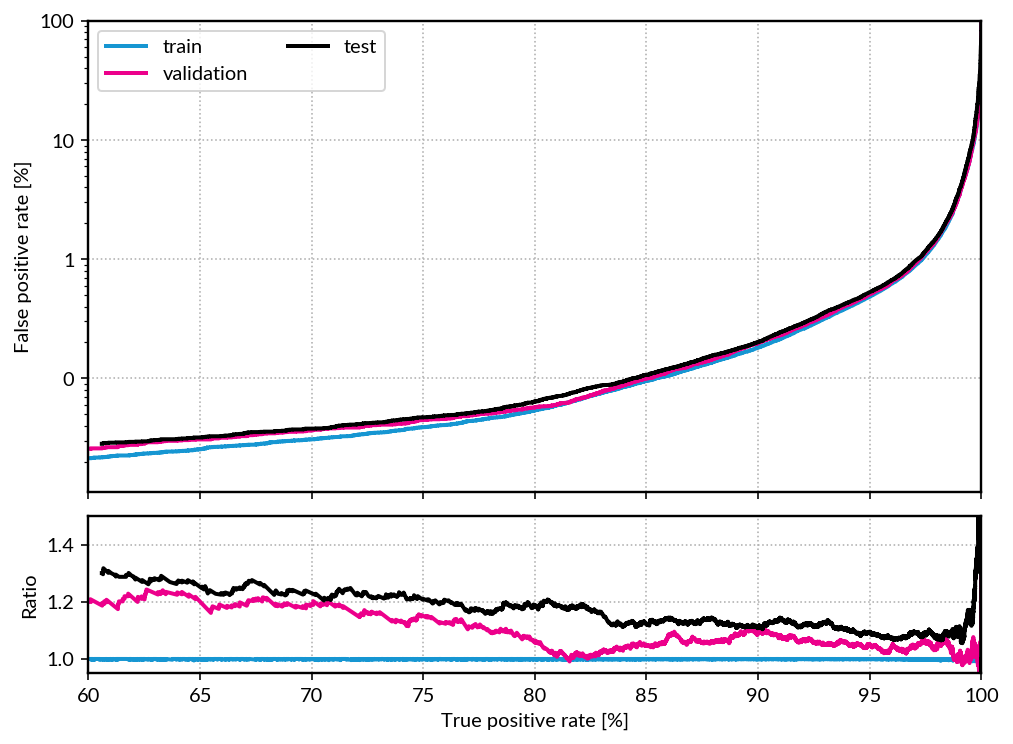

In [17]:
plt.figure(figsize=(8,6))
roc = ROCPlot(xlim=(0.6,1), ylim=(0.00011, 1), logscale=True, grid=True, percent=True, height_ratios=[3,1], ncol=2, rlim=(0.95, 1.5))
roc.plot(y_train, ytrain_pred, label='train')
roc.plot(y_val, yval_pred, label='validation')
roc.plot(y_test, ytst_pred, label='test')

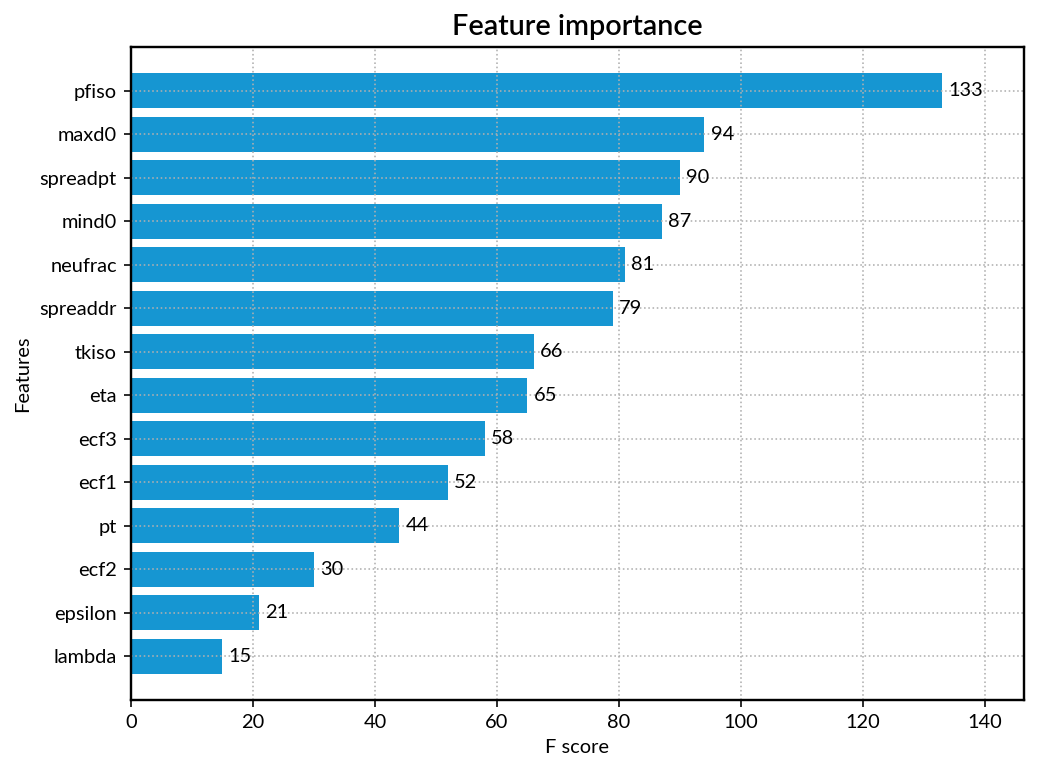

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
xgboost.plot_importance(bst, ax=ax, height=0.8);

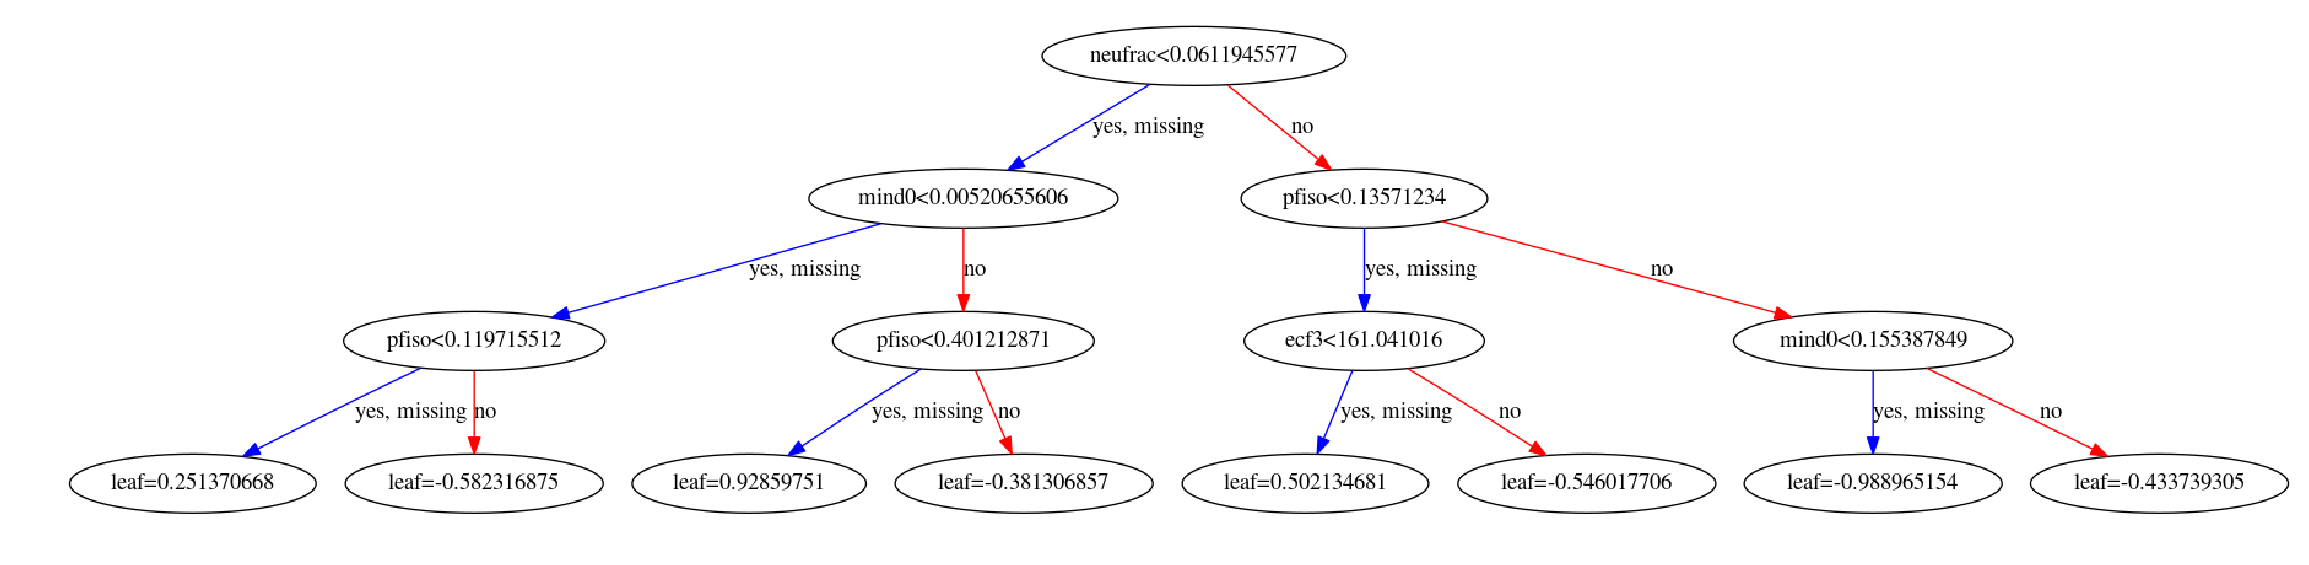

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
xgboost.plot_tree(bst, ax=ax);

In [19]:
varNameType = [(n, 'F') for n in feature_names]
outputFileName = './data/xgboost.xml'

convert_model(
    bst.get_dump(),
    input_variables=varNameType,
    output_xml=outputFileName
)

In [20]:
!xmllint --format ./data/xgboost.xml > ./data/xgboost_formated.xml

---

# tune hyperparameters

In [10]:
def modelfit(algo, trainDf, label, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = algo.get_xgb_params()
        dtrain = xgb.DMatrix(trainDf.values, label=label)
        cvresult = xgb.cv(
            xgb_param, dtrain,
            num_boost_round=algo.get_params()['n_estimators'],
            nfold=cv_folds,
            metrics='auc',
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )
        algo.set_params(n_estimators=cvresult.shape[0])
        
    # fit algorithm on data
    algo.fit(trainDf, label, eval_metric='auc')
    #predict training set
    y_predictions = algo.predict(trainDf)
    y_predprob = algo.predict_proba(trainDf)[:, 1]

    # print model report
    print("\nModel Report")
    print("Accuracy: {:.4g}".format(accuracy_score(label, y_predictions)))
    print("AUC Score: {:.4g}".format(roc_auc_score(label, y_predprob)))

    xgb.plot_importance(algo.get_booster(), height=0.8)

In [11]:
trainvalDf = pd.DataFrame(X_trainVal, columns=feature_names)
trainvalLbl = y_trainVal

## step1: Fix learning rate and number of estimators for tuning tree-based parameters


Model Report
Accuracy: 0.993
AUC Score: 0.999


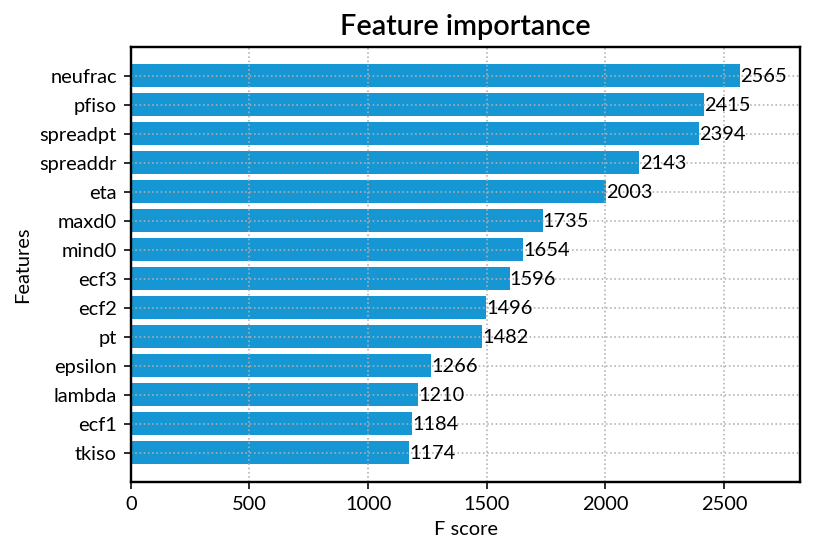

In [12]:
xgb1 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000, # I change this number to a high value
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=16,
    scale_pos_weight=1,
    seed=27
)
modelfit(xgb1, trainvalDf, trainvalLbl)

## step2: Tune max_depth and min_child_weight

In [35]:
param_test1 = dict(
    max_depth=range(3, 10, 2),
    min_child_weight=range(1,6,2)
)

gsearch1 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=4, # I change this number to a low value, should be sth like 140
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=16,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test1,
    scoring='roc_auc',
    n_jobs=12,
    iid=False,
    cv=5
)

gsearch1.fit(trainvalDf, trainvalLbl)
gsearch1.best_params_, gsearch1.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [37]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 3}, 0.9959140402638242)

In [43]:
print(*zip(gsearch1.cv_results_['mean_test_score'], gsearch1.cv_results_['std_test_score'], gsearch1.cv_results_['params']), sep='\n')

(0.9830534391529537, 0.0030853049166608974, {'max_depth': 3, 'min_child_weight': 1})
(0.9830534391529537, 0.0030853049166608974, {'max_depth': 3, 'min_child_weight': 3})
(0.9830534391529537, 0.0030853049166608974, {'max_depth': 3, 'min_child_weight': 5})
(0.9898608552875661, 0.0009026416227081019, {'max_depth': 5, 'min_child_weight': 1})
(0.9898664648617771, 0.0009070064154430089, {'max_depth': 5, 'min_child_weight': 3})
(0.9898663230823915, 0.0009070076504109973, {'max_depth': 5, 'min_child_weight': 5})
(0.9935359791913397, 0.00048756433913728445, {'max_depth': 7, 'min_child_weight': 1})
(0.9935322407181765, 0.000495452124154864, {'max_depth': 7, 'min_child_weight': 3})
(0.993574371324951, 0.0005335970082199802, {'max_depth': 7, 'min_child_weight': 5})
(0.9958867515974378, 0.00032919135022186133, {'max_depth': 9, 'min_child_weight': 1})
(0.9959140402638242, 0.00037296023230060733, {'max_depth': 9, 'min_child_weight': 3})
(0.9958541650314829, 0.0003584064725925356, {'max_depth': 9, 'mi

one above and one below

In [44]:
param_test2 = dict(
    max_depth=[8,9,10],
    min_child_weight=[2,3,4]
)

gsearch2 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=4, # I change this number to a low value, should be sth like 140
        max_depth=5,
        min_child_weight=2,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=16,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test2,
    scoring='roc_auc',
    n_jobs=12,
    iid=False,
    cv=5
)

gsearch2.fit(trainvalDf, trainvalLbl)
gsearch2.best_params_, gsearch2.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

`min_child_weight` more than 6

In [ ]:
param_test2b = dict(
    min_child_weight=[6,8,10,12]
)

gsearch2b = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=140, # I change this number to a high value
        max_depth=5, # this is set as the optimal numbe above
        min_child_weight=2,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=16,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test2b,
    scoring='roc_auc',
    n_jobs=12,
    iid=False,
    cv=5
)

gsearch2b.fit(trainvalDf, trainvalLbl)
gsearch2b.best_params_, gsearch2b.best_score_

we should have optimal value for `max_depth` and `min_child_weight` now.

## step3: Tune gamma

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=140, # I change this number to a high value
        max_depth=5, # this is set as the optimal numbe above
        min_child_weight=2, # this is set as the optimal value from above
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=16,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test3,
    scoring='roc_auc',
    n_jobs=12,
    iid=False,
    cv=5
)

gsearch3.fit(trainvalDf, trainvalLbl)
gsearch3.best_params_, gsearch3.best_score_

**recalibrate the number of boosting rounds for the updated parameters**

In [ ]:
xgb2 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000, # I change this number to a high value
    max_depth=5, # should be optimal value
    min_child_weight=1, # should be optimal value
    gamma=0, # should be optimal value
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=16,
    scale_pos_weight=1,
    seed=27
)
modelfit(xgb2, trainvalDf, trainvalLbl)

So far, we determine the parameters for
- max_depth
- min_child_weight
- gamma

## Step4: Tune subsample and colsample_bytree

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=140, # should be updated to a new value
        max_depth=5, # this is set as the optimal numbe above
        min_child_weight=2, # this is set as the optimal value from above
        gamma=0, # optimal
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=16,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test4,
    scoring='roc_auc',
    n_jobs=12,
    iid=False,
    cv=5
)

gsearch4.fit(trainvalDf, trainvalLbl)
gsearch4.best_params_, gsearch4.best_score_

in 0.05 interval around the optimal value found

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

gsearch5 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=140, # should be updated to a new value
        max_depth=5, # this is set as the optimal numbe above
        min_child_weight=2, # this is set as the optimal value from above
        gamma=0, # optimal
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=16,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test5,
    scoring='roc_auc',
    n_jobs=12,
    iid=False,
    cv=5
)

gsearch5.fit(trainvalDf, trainvalLbl)
gsearch5.best_params_, gsearch5.best_score_

- subsample = ?
- colsample_bytree = ?

## step5: Tune regularization parameters

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=140, # should be updated to a new value
        max_depth=5, # this is set as the optimal numbe above
        min_child_weight=2, # this is set as the optimal value from above
        gamma=0, # optimal
        subsample=0.8, # optimal
        colsample_bytree=0.8, # optimal
        objective='binary:logistic',
        nthread=16,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test6,
    scoring='roc_auc',
    n_jobs=12,
    iid=False,
    cv=5
)

gsearch6.fit(trainvalDf, trainvalLbl)
gsearch6.best_params_, gsearch6.best_score_

if score not improving, try a different range

In [ ]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

gsearch7 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=140, # should be updated to a new value
        max_depth=5, # this is set as the optimal numbe above
        min_child_weight=2, # this is set as the optimal value from above
        gamma=0, # optimal
        subsample=0.8, # optimal
        colsample_bytree=0.8, # optimal
        objective='binary:logistic',
        nthread=16,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test7,
    scoring='roc_auc',
    n_jobs=12,
    iid=False,
    cv=5
)

gsearch7.fit(trainvalDf, trainvalLbl)
gsearch7.best_params_, gsearch7.best_score_

**apply regularization to the model**

In [ ]:
xgb3 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000, # I change this number to a high value
    max_depth=5, # should be optimal value
    min_child_weight=1, # should be optimal value
    gamma=0, # should be optimal value
    subsample=0.8, # optimal
    colsample_bytree=0.8, # optimal
    reg_alpha=0.005, # optimal
    objective='binary:logistic',
    nthread=16,
    scale_pos_weight=1,
    seed=27
)
modelfit(xgb3, trainvalDf, trainvalLbl)

## step6: Reduce learning rate

In [ ]:
xgb4 = xgb.XGBClassifier(
    learning_rate=0.01,
    n_estimators=5000, # I change this number to a high value
    max_depth=5, # should be optimal value
    min_child_weight=1, # should be optimal value
    gamma=0, # should be optimal value
    subsample=0.8, # optimal
    colsample_bytree=0.8, # optimal
    reg_alpha=0.005, # optimal
    objective='binary:logistic',
    nthread=16,
    scale_pos_weight=1,
    seed=27
)
modelfit(xgb4, trainvalDf, trainvalLbl)

---

In [7]:
xgb_clf = xgboost.XGBClassifier(n_estimators=200, n_jobs=16, learning_rate=0.5)
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    early_stopping_rounds=5,
    eval_metric='logloss',
)
y_pred = xgb_clf.predict(X_val)

[0]	validation_0-logloss:0.335862	validation_1-logloss:0.335763
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.199139	validation_1-logloss:0.198837
[2]	validation_0-logloss:0.129339	validation_1-logloss:0.129153
[3]	validation_0-logloss:0.091086	validation_1-logloss:0.090764
[4]	validation_0-logloss:0.068744	validation_1-logloss:0.068422
[5]	validation_0-logloss:0.055539	validation_1-logloss:0.055076
[6]	validation_0-logloss:0.047202	validation_1-logloss:0.046719
[7]	validation_0-logloss:0.042536	validation_1-logloss:0.042046
[8]	validation_0-logloss:0.039626	validation_1-logloss:0.039151
[9]	validation_0-logloss:0.03781	validation_1-logloss:0.037308
[10]	validation_0-logloss:0.035915	validation_1-logloss:0.035461
[11]	validation_0-logloss:0.035088	validation_1-logloss:0.034604
[12]	validation_0-logloss:0.034419	validation_1-logloss:0.033928
[1

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.9912628982230661

In [23]:
feaimp = {}
for name, val in zip(list(dataset_.keys())[1:], xgb_clf.feature_importances_):
    print('{:>10} {:.4f}'.format(name, val))
    feaimp[name] = val

        pt 0.0065
       eta 0.0039
   neufrac 0.5995
     maxd0 0.0194
     mind0 0.1025
     tkiso 0.0079
     pfiso 0.1690
  spreadpt 0.0100
  spreaddr 0.0132
    lambda 0.0012
   epsilon 0.0019
      ecf1 0.0181
      ecf2 0.0093
      ecf3 0.0375


In [24]:
from collections import OrderedDict

feaimp_sorted = OrderedDict(sorted(feaimp.items(), key=lambda kv: kv[1]))

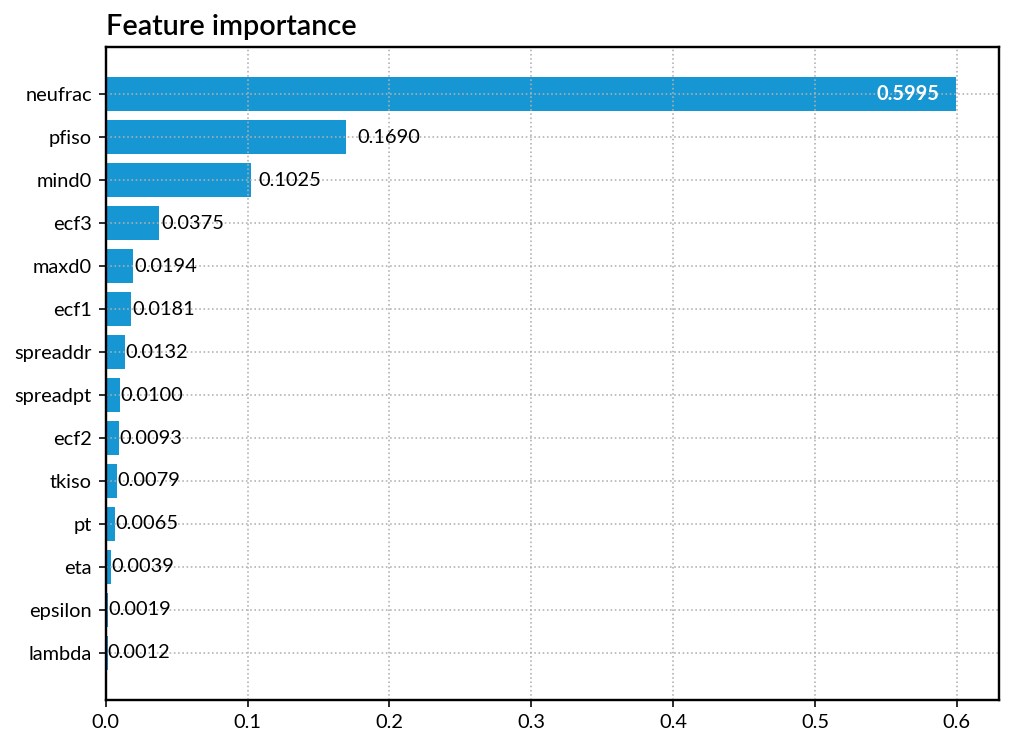

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(range(len(feaimp_sorted)), list(feaimp_sorted.values()), tick_label=list(feaimp_sorted.keys()))
for i, k in enumerate(feaimp_sorted):
    if feaimp_sorted[k]<0.3:
        ax.text(
            feaimp_sorted[k]*1.05, i, '{:.4f}'.format(feaimp_sorted[k]),
            ha='left', va='center', fontsize=10
        )
    else:
        ax.text(
            feaimp_sorted[k]*0.98, i, '{:.4f}'.format(feaimp_sorted[k]),
            ha='right', va='center', fontsize=10, color='w', weight='bold'
        )
plt.title('Feature importance', ha='left', x=0);

## accuracy score

In [26]:
accuracy_score(y_test, xgb_clf.predict(X_test))

ValueError: feature_names mismatch: ['pt', 'eta', 'neufrac', 'maxd0', 'mind0', 'tkiso', 'pfiso', 'spreadpt', 'spreaddr', 'lambda', 'epsilon', 'ecf1', 'ecf2', 'ecf3'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13']
expected tkiso, maxd0, ecf2, eta, neufrac, lambda, ecf1, pfiso, spreadpt, epsilon, mind0, pt, spreaddr, ecf3 in input data
training data did not have the following fields: f3, f13, f8, f0, f7, f1, f5, f11, f2, f9, f10, f12, f6, f4

## validation loss

In [27]:
losses = xgb_clf.evals_result_
bst_n_estimators0 = np.argmin(losses['validation_0']['logloss'])
bst_n_estimators1 = np.argmin(losses['validation_1']['logloss'])
min_losses0 = np.min(losses['validation_0']['logloss'])
min_losses1 = np.min(losses['validation_1']['logloss'])

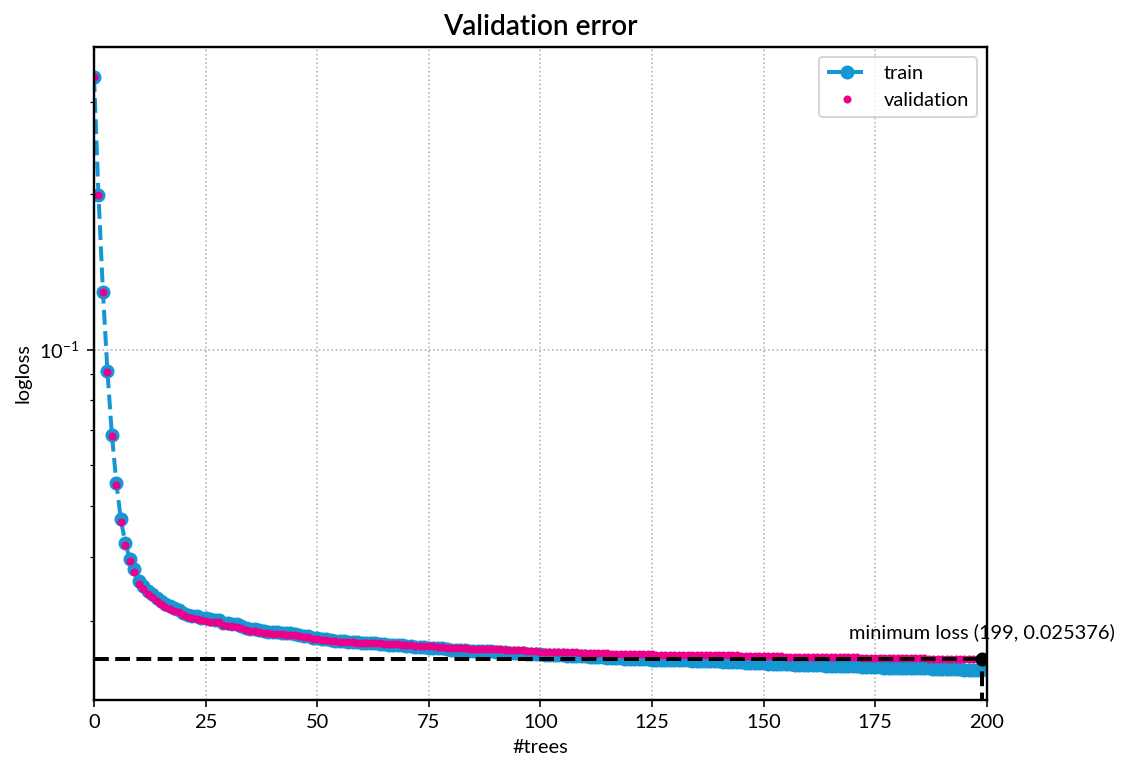

In [28]:
plt.figure(figsize=(8,6))
plt.plot(losses['validation_0']['logloss'], 'o--', label='train')
plt.plot(losses['validation_1']['logloss'], '.', label='validation')

plt.plot([bst_n_estimators1, bst_n_estimators1], [0, min_losses1], 'k--')
plt.plot([0, 200], [min_losses1, min_losses1], 'k--')
plt.plot(bst_n_estimators1, min_losses1, 'ko')
plt.text(bst_n_estimators1, min_losses1*1.1, f"minimum loss ({bst_n_estimators1}, {min_losses1})", ha='center')

# plt.axis([0, 200, 0, 0.5])
plt.xlabel("#trees")
plt.ylabel("logloss")
plt.yscale('log')
plt.xlim([0, 200])
plt.title("Validation error", fontsize=14)
plt.legend();

In [29]:
bst_n_estimators1

199

## ROC curve

In [30]:
y_score = xgb_clf.predict_proba(X_test)[:,1]

ValueError: feature_names mismatch: ['pt', 'eta', 'neufrac', 'maxd0', 'mind0', 'tkiso', 'pfiso', 'spreadpt', 'spreaddr', 'lambda', 'epsilon', 'ecf1', 'ecf2', 'ecf3'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13']
expected tkiso, maxd0, ecf2, eta, neufrac, lambda, ecf1, pfiso, spreadpt, epsilon, mind0, pt, spreaddr, ecf3 in input data
training data did not have the following fields: f3, f13, f8, f0, f7, f1, f5, f11, f2, f9, f10, f12, f6, f4

In [70]:
plt.hist(y_score)

NameError: name 'y_score' is not defined

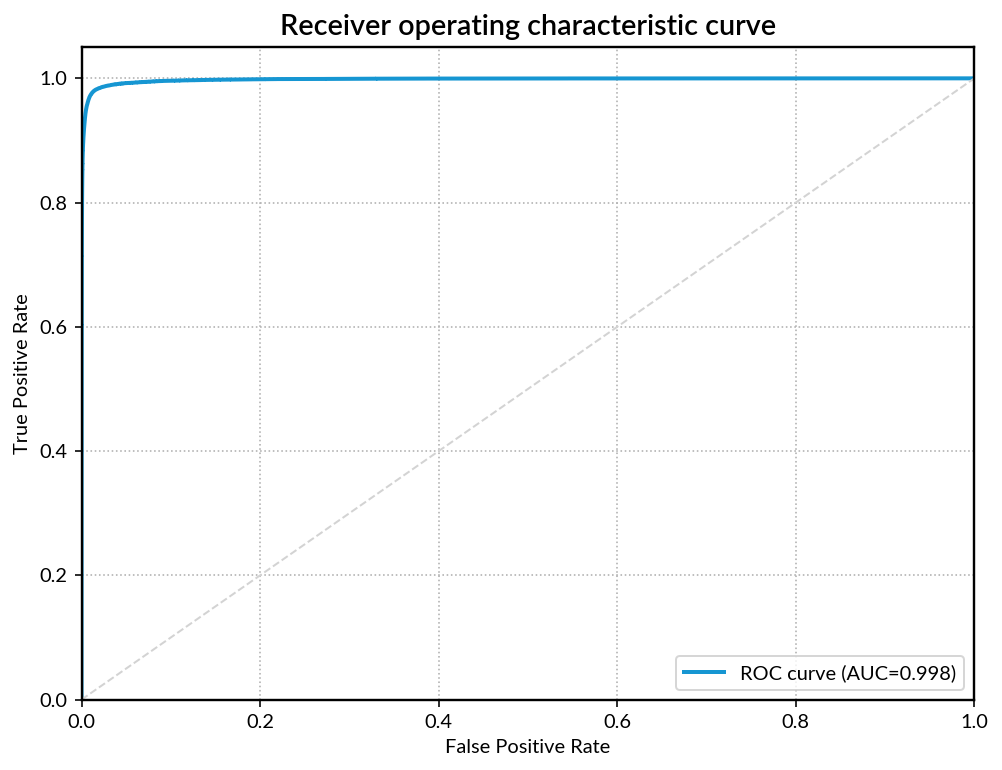

In [18]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC={:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='lightgrey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right");

## PR curve

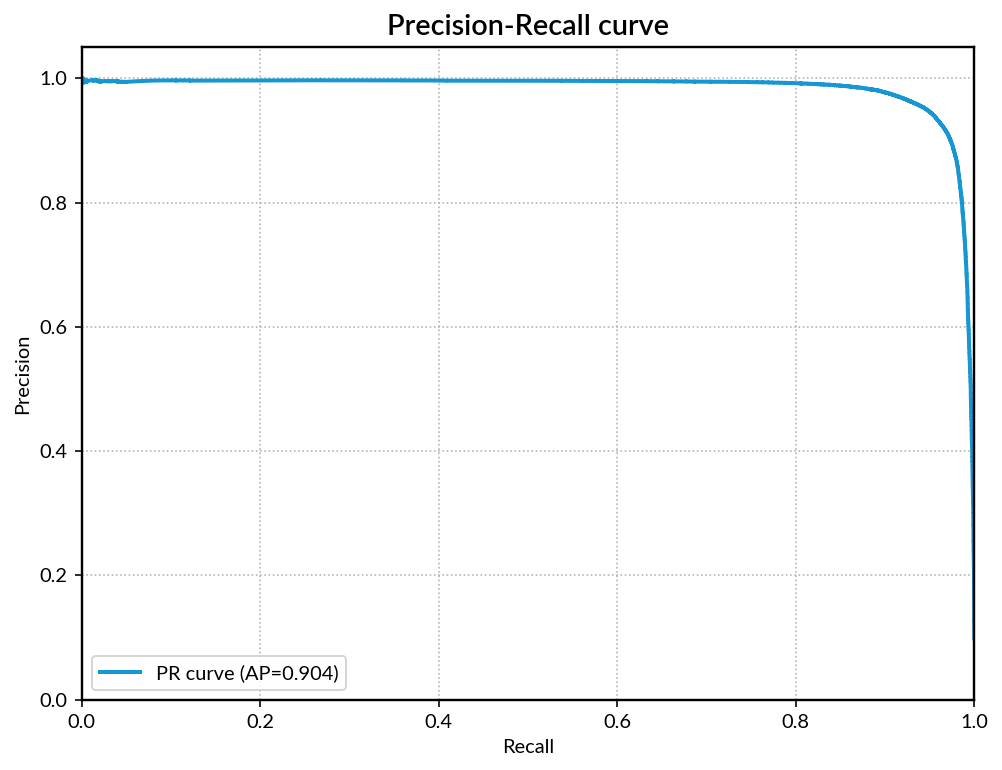

In [19]:
from sklearn.metrics import average_precision_score, precision_recall_curve

predictions = xgb_clf.predict(X_test)
ave_precision = average_precision_score(y_test, predictions)
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.figure(figsize=(8,6))
plt.step(recall, precision, where='post', label='PR curve (AP={:.3f})'.format(ave_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc='best');

## confusion matrix

In [20]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = pd.DataFrame(confusion_matrix(y_test, predictions))
cm['Total'] = np.sum(cm, axis=1)
cm = cm.append(np.sum(cm, axis=0), ignore_index=True)
cm.columns = ['Predicted No', 'Predicted Yes', 'Total']
cm = cm.set_index([['Actual No', 'Actual Yes', 'Total']])
cm

,Predicted No,Predicted Yes,Total
Actual No,653513,2857,656370
Actual Yes,3550,58396,61946
Total,657063,61253,718316


In [21]:
print(cm)

            Predicted No  Predicted Yes   Total
Actual No         653513           2857  656370
Actual Yes          3550          58396   61946
Total             657063          61253  718316


## classification report

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

       False     0.9946    0.9956    0.9951    656370
        True     0.9534    0.9427    0.9480     61946

   micro avg     0.9911    0.9911    0.9911    718316
   macro avg     0.9740    0.9692    0.9716    718316
weighted avg     0.9910    0.9911    0.9911    718316



----

## preserve model as xml for tmva

In [8]:
bst = xgb_clf.get_booster()
bst.__dict__['feature_names'] = list(dataset_.keys())[1:]
model = bst.get_dump()

In [13]:
from mvatrain.xgboost2tmva import convert_model

varName_ = list(dataset_.keys())[1:]
varNameType = [(n, 'F') for n in varName_]
outputFileName = './data/xgboost.xml'

convert_model(model, varNameType, outputFileName)

In [14]:
!xmllint --format ./data/xgboost.xml > ./data/xgboost_formated.xml

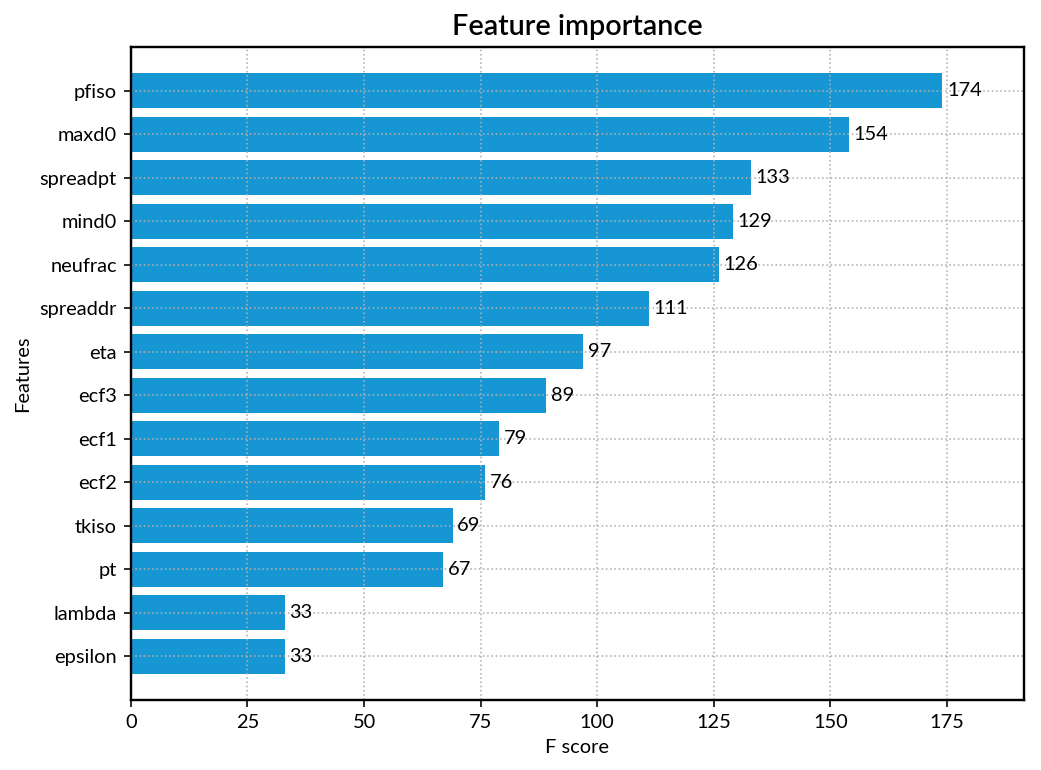

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
xgboost.plot_importance(bst, ax=ax, height=0.8);

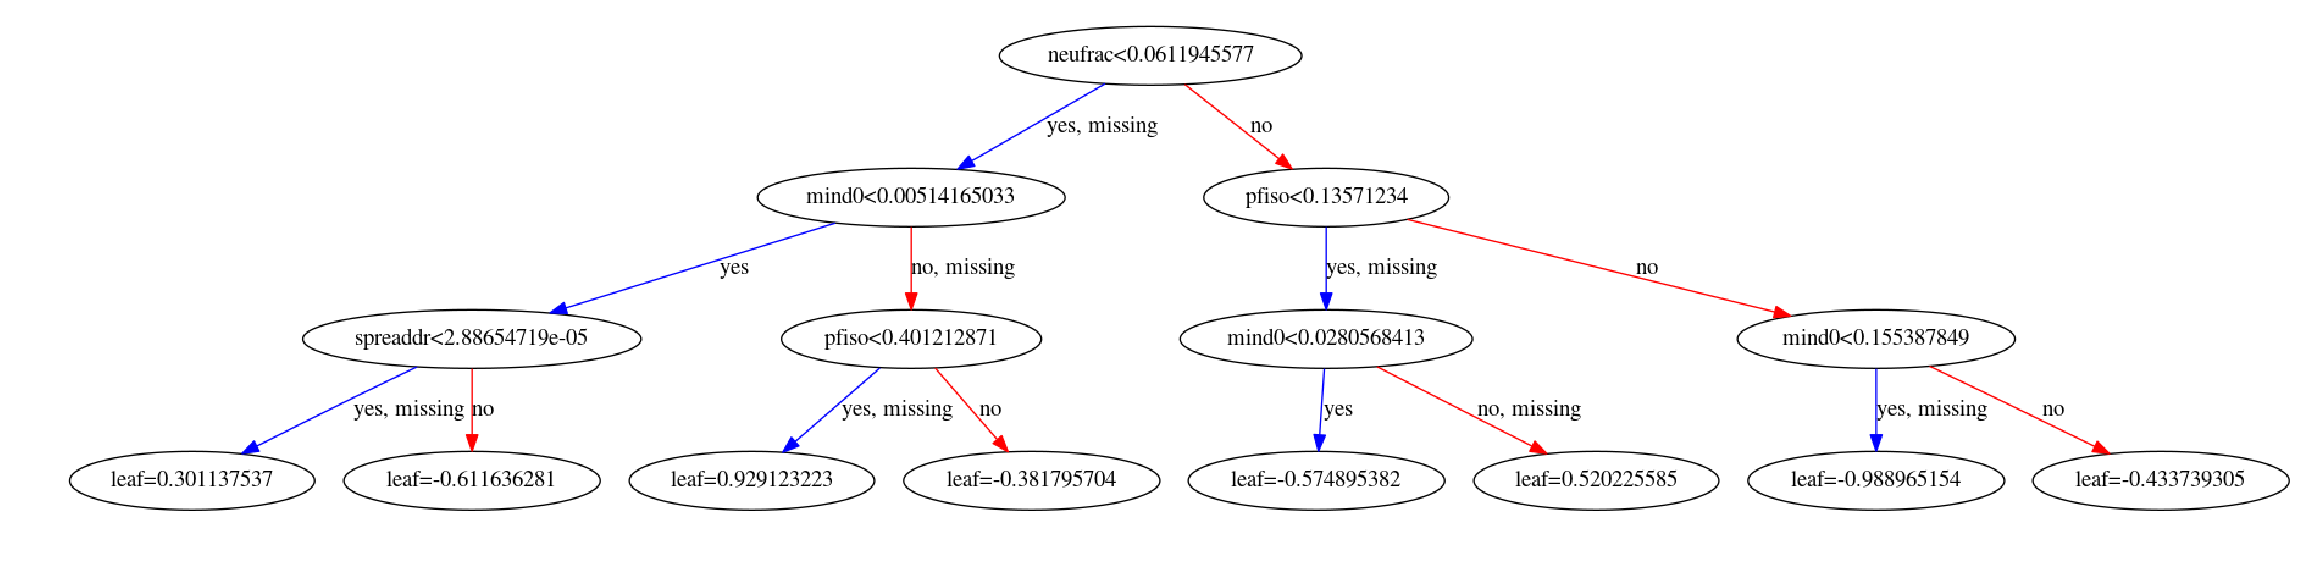

In [16]:
fig, ax = plt.subplots(figsize=(20,20))
xgboost.plot_tree(bst, ax=ax);